In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pickle
from eval_utils import cross_boundary_correctness
import matplotlib.pyplot as plt
import pandas as pd
import pyrovelocity
import unitvelo as utv
from os.path import exists
from pyrovelocity.api import train_model
method = 'pyroVelocity_model2'

(Running UniTVelo 0.2.5.1)
2023-01-20 14:27:27


In [2]:
def compute_mean_vector_field(
    pos,
    adata,
    basis="umap",
    n_jobs=1,
    spliced="spliced_pyro",
    raw=False,
):
    scv.pp.neighbors(adata, use_rep="pca")

    adata.var["velocity_genes"] = True

    if spliced == "spliced_pyro":
        if raw:
            ut = pos["ut"]
            st = pos["st"]
            ut = ut / ut.sum(axis=-1, keepdims=True)
            st = st / st.sum(axis=-1, keepdims=True)
        else:
            ut = pos["ut"]
            st = pos["st"]
        adata.layers["spliced_pyro"] = st.mean(0).squeeze()
        # if ('u_scale' in pos) and ('s_scale' in pos): # TODO: two scale for Normal distribution
        if "u_scale" in pos:  # only one scale for Poisson distribution
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / pos["u_scale"] - st * pos["gamma"]
            ).mean(0)
        else:
            if "beta_k" in pos:
                adata.layers["velocity_pyro"] = (
                    (ut * pos["beta_k"] - pos["st"] * pos["gamma_k"]).mean(0).squeeze()
                )
            else:
                adata.layers["velocity_pyro"] = (
                    ut * pos["beta"] - pos["st"] * pos["gamma"]
                ).mean(0)
        scv.tl.velocity_graph(
            adata, vkey="velocity_pyro", xkey="spliced_pyro", n_jobs=n_jobs
        )
    elif spliced in ["Ms"]:
        ut = adata.layers["Mu"]
        st = adata.layers["Ms"]
        if ("u_scale" in pos) and ("s_scale" in pos):
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / (pos["u_scale"] / pos["s_scale"]) - st * pos["gamma"]
            ).mean(0)
        else:
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] - pos["st"] * pos["gamma"]
            ).mean(0)
        scv.tl.velocity_graph(adata, vkey="velocity_pyro", xkey="Ms", n_jobs=n_jobs)
    elif spliced in ["spliced"]:
        ut = adata.layers["unspliced"]
        st = adata.layers["spliced"]
        if ("u_scale" in pos) and ("s_scale" in pos):
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / (pos["u_scale"] / pos["s_scale"]) - st * pos["gamma"]
            ).mean(0)
        else:
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] - pos["st"] * pos["gamma"]
            ).mean(0)
        scv.tl.velocity_graph(
            adata, vkey="velocity_pyro", xkey="spliced", n_jobs=n_jobs
        )

    scv.tl.velocity_embedding(adata, vkey="velocity_pyro", basis=basis)

In [3]:
dataset = 'MouseErythroid'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 9815 cells, 3000 vars, 1 batches, 1 l

Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 9815  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
step    0 loss = 6.76887e+08 patience = 45
step  100 loss = 4.31873e+08 patience = 45
step  200 loss = 3.85903e+08 patience = 43
step  300 loss = 3.64355e+08 patience = 43
step  400 loss = 3.53556e+08 patience = 45
step  500 loss = 3.48217e+08 patience = 31
step  600 loss = 3.45202e+08 patience = 36
step  700 loss = 3.43846e+08 patience = 26
step  800 loss = 3.4346e+08 patience = 39
step  900 loss = 3.43104e+08 patience = 35
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:01:33) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.9091416947436833, ('Blood progenitors 2', 'Erythroid1'): 0.8065732878768853, ('Erythroid1', 'Erythroid2'): 0.8426566899727834, ('Erythroid2', 'Erythroid3'): 0.8314463142549767}
Total Mean: 0.8474544967120822
# In-cluster Coherence
{'Blood progenitors 1': 0.80518085, 'Blood progenitors 2': 0.7254092, 'Erythroid1': 0.67482334, 'Erythroid2': 0.68407726, 'Erythroid3': 0.8362193}
Total Mean: 0.7451419830322266
# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.9091416947436833, ('Blood progenitors 2', 'Erythroid1'): 0.8065732878768853, ('Erythroid1', 'Erythroid2'): 0.8426566899727834, ('Erythroid2', 'Erythroid3'): 0.831446314

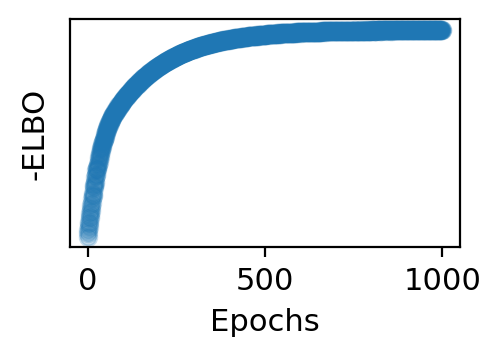

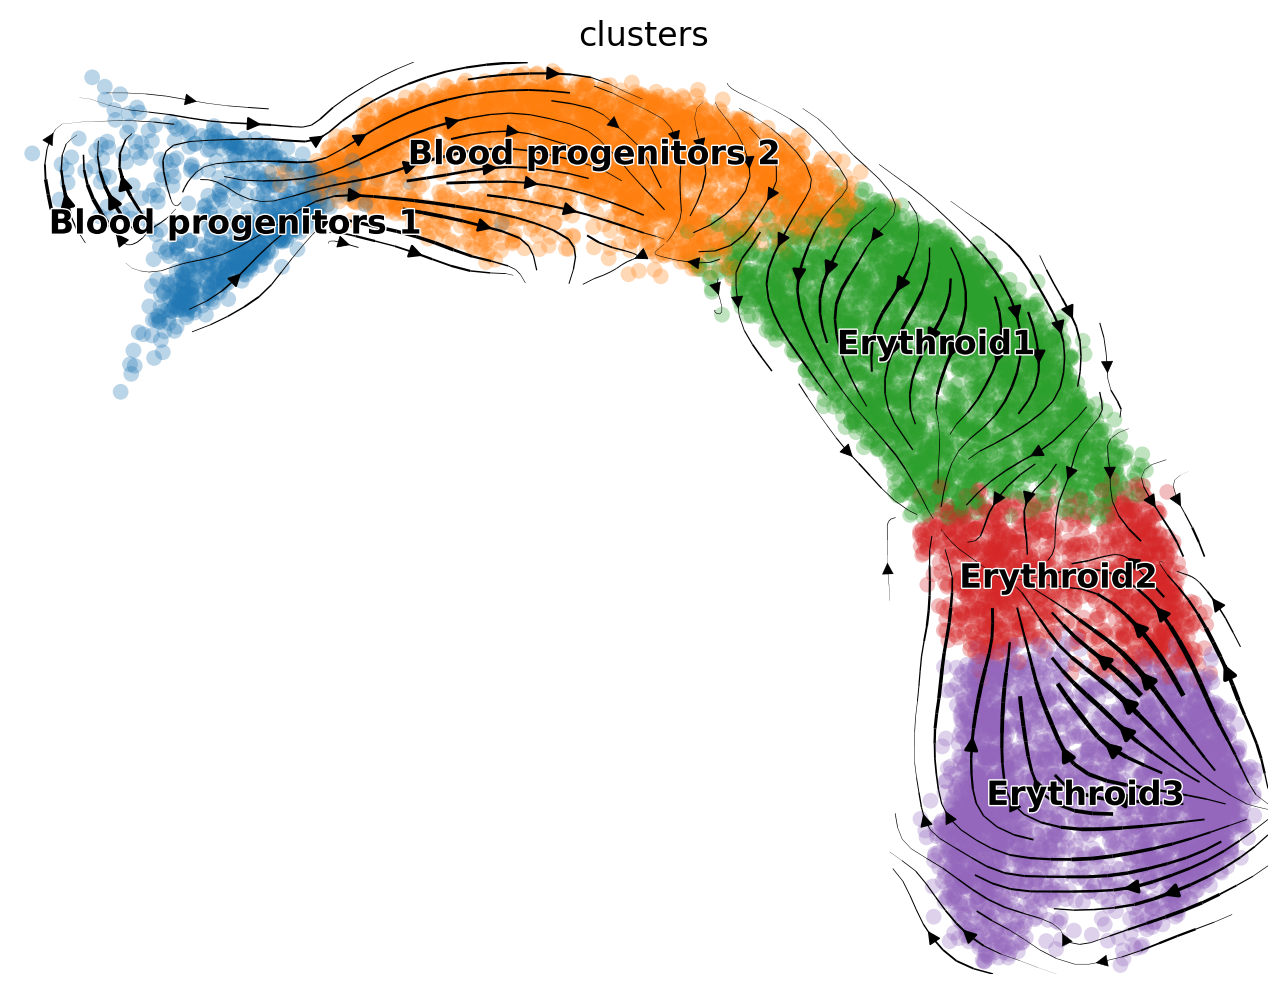

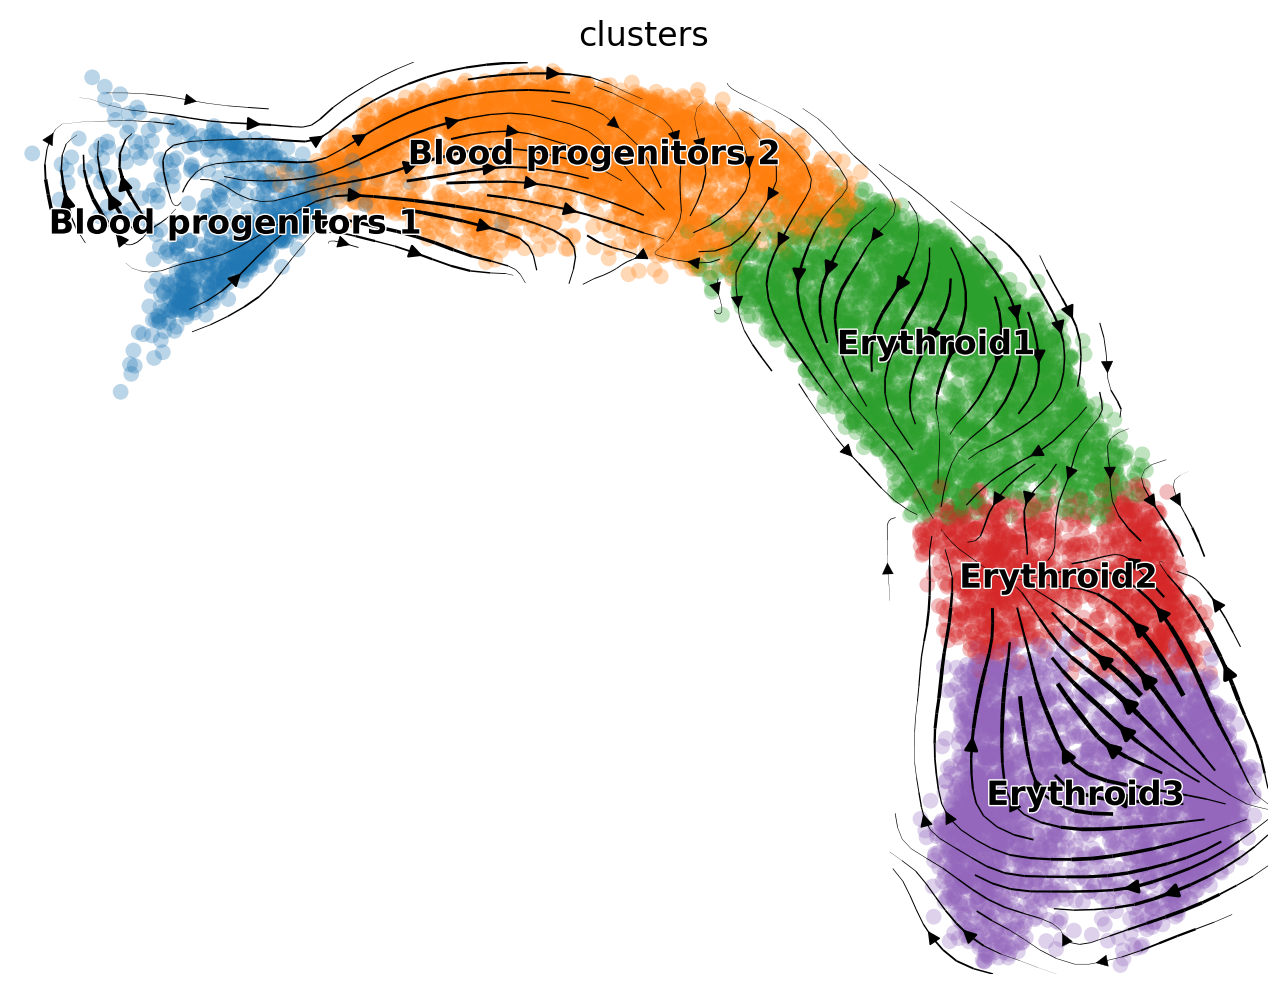

In [4]:
adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
adata.layers['raw_spliced']   = adata.layers['spliced']
adata.layers['raw_unspliced'] = adata.layers['unspliced']
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.obs['u_lib_size_raw'] = adata.layers['raw_unspliced'].toarray().sum(-1)
adata.obs['s_lib_size_raw'] = adata.layers['raw_spliced'].toarray().sum(-1)
# Model 1
num_epochs = 1000 # large data
adata_model_pos = train_model(adata,
                               max_epochs=num_epochs, svi_train=True, log_every=100,
                               patient_init=45,
                               batch_size=4000, use_gpu=0, cell_state='state_info',
                               include_prior=True,
                               offset=True,
                               library_size=True,
                               patient_improve=1e-3,
                               model_type='auto',
                               guide_type='auto',
                               train_size=1.0)
compute_mean_vector_field(adata_model_pos[1], adata)
scv.tl.velocity_graph(adata, vkey = 'velocity')
scv.tl.velocity_embedding(adata, vkey = 'velocity')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_pyroVelocity_model2.png')
# Calculate performance metrics:
file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
ground_truth = pickle.load(file)
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
if exists(save_dir + dataset + '_CBDC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean'],
             index = [method])
cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
            for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
tab.loc[method,:] = cb_score + [np.mean(cb_score)]
tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
if exists(save_dir + dataset + '_ICC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_ICC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(np.unique(np.concatenate(ground_truth))) + ['Mean'],
             index = [method])
icc_score = [np.mean(metrics['In-cluster Coherence'][x]) for x in np.unique(np.concatenate(ground_truth))]
tab.loc[method,:] = icc_score + [np.mean(icc_score)]
tab.to_csv(save_dir + dataset + '_ICC_scores.csv')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.png')

In [5]:
alpha_pyroVel = (np.sum(adata_model_pos[1]['cell_gene_state'], axis = 0)/30 > 0.5)*np.sum(adata_model_pos[1]['alpha'], axis = 0)

In [6]:
pickle.dump(alpha_pyroVel, open('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/' + "alpha_pyroVel.p", "wb" ) )

In [16]:
time_pyroVel = np.sum(adata_model_pos[1]['cell_time'], axis = 0)
pickle.dump(time_pyroVel, open('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/' + "time_pyroVel.p", "wb" ))

In [22]:
alpha_pyroVel.shape

(9815, 3000)

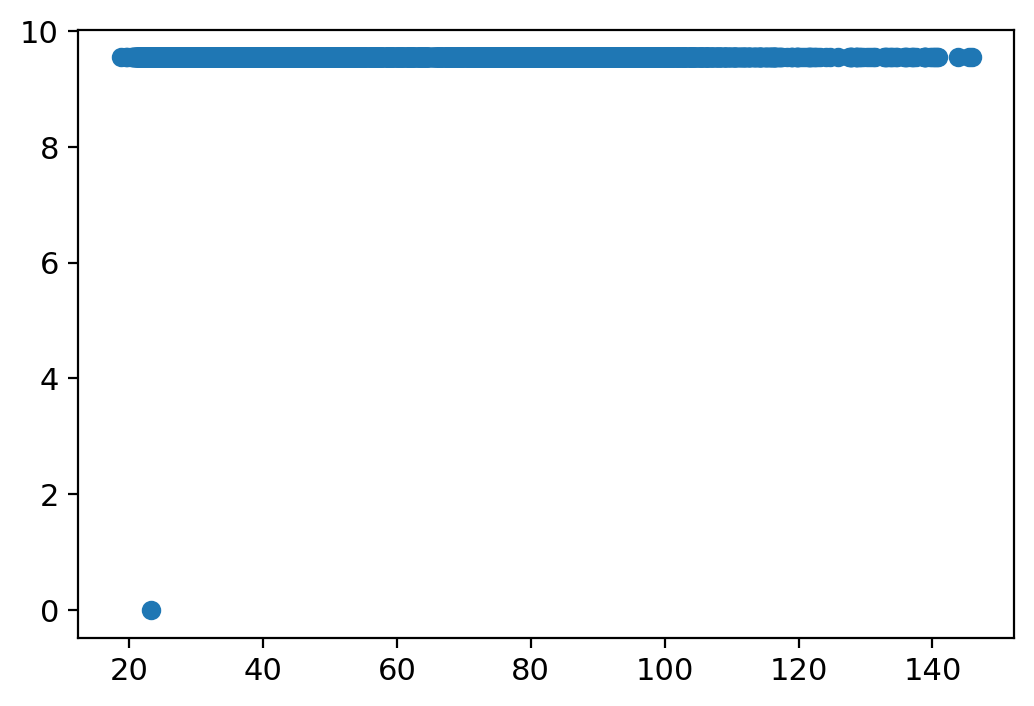

In [29]:
plt.scatter(time_pyroVel, alpha_pyroVel[:,adata.var_names == 'Smim1'])

In [17]:
pickle.dump(adata.var_names, open('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/' + "varnames_pyroVel.p", "wb" ))

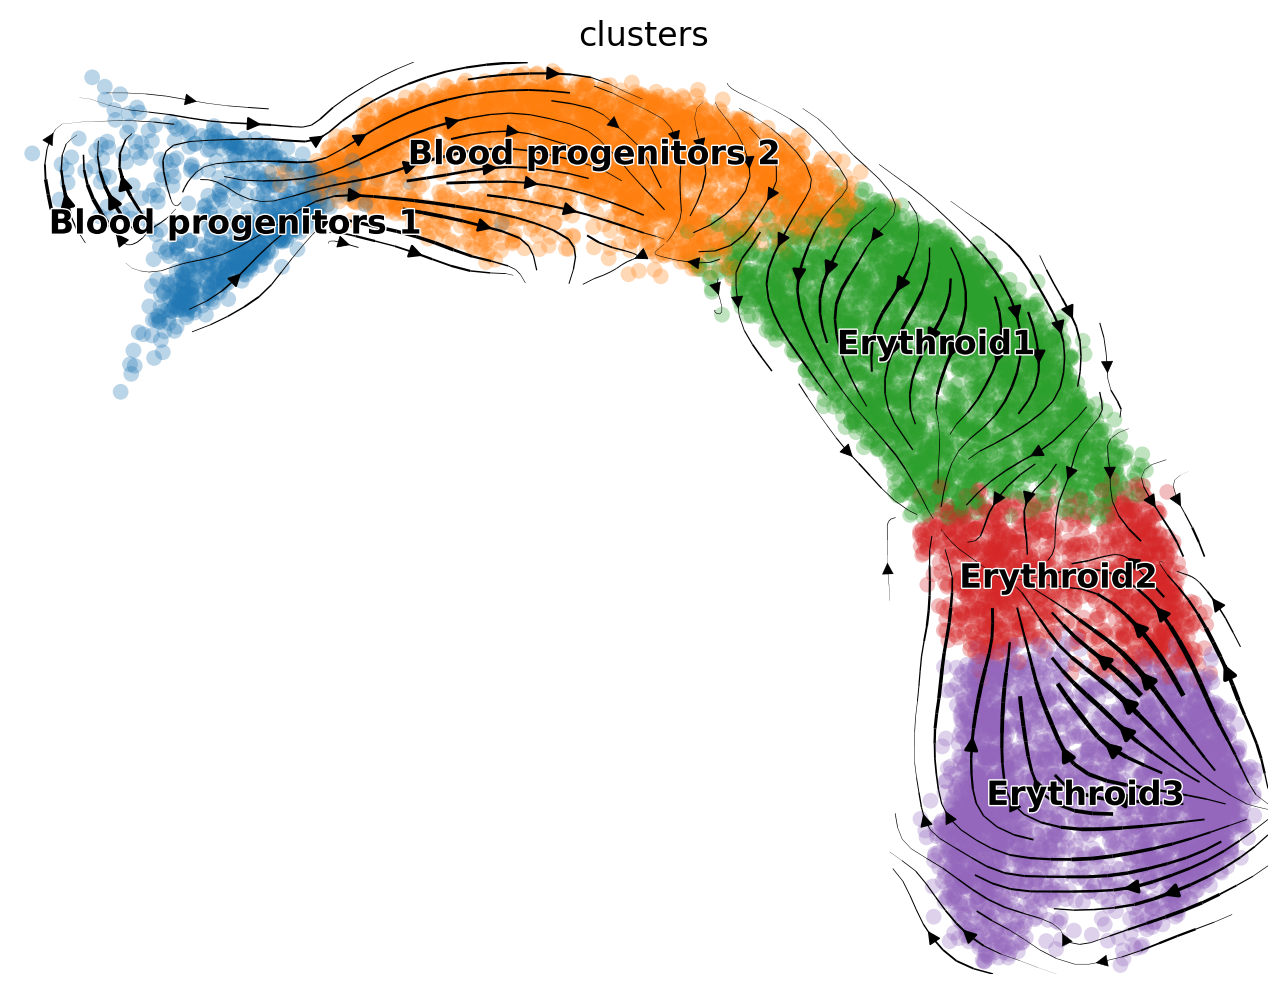

In [8]:
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.svg')